# Laboratorio: Classificazione

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Proff. Gianluca Moro, Roberto Pasolini  
`nome.cognome@unibo.it`

## Classificazione

- Nei problemi visti finora di _regressione_, l'obiettivo è prevedere il valore di una variabile _continua_
  - una quantità di energia consumata, il prezzo di una casa, ...
- Nei problemi di **_classificazione_** l'obiettivo generale è invece, per ogni osservazione, **distinguere uno di due o più casi (_classi_) possibili**
- Come per la regressione, un modello di classificazione va addestrato su esempi già correttamente classificati

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Caso di Studio 1: Predizione Default Carte di Credito

- La predizione del rischio di credito è importante per le banche per stimare in anticipo il capitale che avranno a disposizione
- Dati dei titolari di carte di credito, vogliamo predire per ogni mese se rimborseranno puntualmente le spese effettuate
- Su https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients è fornito un dataset che riassume lo stato di 30.000 titolari di carte di credito di una banca in Taiwan nel 2005
- Utilizziamo questo dataset per verificare se siamo in grado di addestrare un modello a predire l'insolvenza o meno dei titolari di carte

## Reperimento dei Dati

- I dati sono forniti in un file Excel, utilizziamo la funzione `read_excel` di pandas per importarli direttamente dato l'URL del file
  - deve essere installata la libreria `xlrd`
  - con `skiprows=1` ignoriamo la prima riga del file

In [3]:
ccd_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
ccd = pd.read_excel(ccd_url, skiprows=1)

- Vediamo il numero di righe e colonne

In [4]:
ccd.shape

(30000, 25)

- Di default pandas visualizza al massimo 20 colonne (prime 10 e ultime 10): il seguente comando aumenta tale limite
  - oltre a `max_columns` si può impostare `max_rows` allo stesso modo

In [5]:
pd.options.display.max_columns = 25

In [6]:
ccd.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
0     -2     -2       3913       3102        689          0          0   
1      0      2       2682       1725       2682       3272       3455   
2      0      0      29239      14027      13559      14331      14948   
3      0      0      46990      48233      49291      28314      28959   
4      0      0       8617       5670      35835      20940      19146   

   BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  \
0          0         0       689         0         0         0         0   
1       3261         0      1000      1000      1000         0      2000   
2      15549      1518      1500      1000      1000      1000      5000   
3      29547      2000      2019      1200      1100      1069      1000   
4      19131      2000     36681     10000      9000       689       679   

   default payment next month  
0                           1  
1                           1  
2                           0  
3                           0  
4                           0

## Significato delle Colonne

Riportiamo le informazioni sul dataset tratte dalla [fonte](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)

- **`ID`** è un identificativo unico di ciascun cliente

I seguenti attributi sono di tipo categorico (nominale o ordinale), ma codificati come numeri:
- **`SEX`**: sesso
  - 1 = maschio, 2 = femmina
- **`EDUCATION`**: titolo di studio
  - 1 = laurea specialistica, 2 = laurea breve, 3 = scuola superiore, 4 = altro
- **`MARRIAGE`**: stato civile
  - 1 = sposato, 2 = nubile/celibe, 3 = altro
- **`default payment next month`**: stato pagamento dell'ultimo mese **(variabile da prevedere!)**
  - 0 = pagato, 1 = insoluto

Gli attributi puramente numerici (_intervallo_ o _ratio_) sono invece:
- **`LIMIT_BAL`**: ammontare del credito
- **`AGE`**: età
- **`PAY_x`**: stato del pagamento di x mesi prima
  - -1 = pagato in tempo
  - 1 = pagato un mese in ritardo
  - ...
  - 9 = pagato nove o più mesi in ritardo
- **`BILL_AMTx`**: somma da pagare x mesi prima
- **`PAY_AMTx`**: somma effettivamente pagata x mesi prima

## Preprocessamento di Base

- Per iniziare, impostiamo l'identificatore univoco `ID` come indice del dataset

In [7]:
ccd.set_index("ID", inplace=True)

- Inoltre, per maggiore comprensibilità, cambiamo i nomi di un paio di colonne
  - usiamo il metodo `rename` passando un dizionario che associ i nuovi nomi a quelli attuali

In [8]:
ccd.rename(columns={
    # nome attuale                nuovo nome
    "PAY_0":                      "PAY_1",
    "default payment next month": "DEFAULT"
}, inplace=True)

## Analisi Esplorativa

- Analizziamo la distribuzione dei valori nelle varie colonne
- Iniziamo dalla variabile `DEFAULT` che vogliamo predire
- Col metodo `value_counts` possiamo ottenere sia il conteggio che (con `normalize=True`) la percentuale di valori

In [9]:
ccd["DEFAULT"].value_counts()

0    23364
1     6636
Name: DEFAULT, dtype: int64

In [10]:
ccd["DEFAULT"].value_counts(normalize=True)

0    0.7788
1    0.2212
Name: DEFAULT, dtype: float64

- Nel dataset abbiamo quindi il 22\% circa di casi di insolvenza

- Possiamo visualizzare la stessa informazione in un grafico a torta
  - con l'opzione `labels` di `plot.pie` assegniamo etichette comprensibili ai settori
  - `sort_index` si applica al risultato di `value_counts` per garantire l'ordine delle etichette

In [11]:
ccd["DEFAULT"].value_counts().sort_index() \
    .plot.pie(labels=["Paid", "Default"], figsize=(5, 5))

- Per comodità creiamo una funzione generale per grafici come questo

In [12]:
def pieplot(x, **options):
    x.value_counts().sort_index().plot.pie(**options)

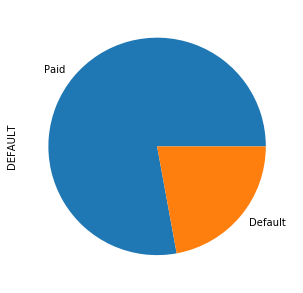

In [13]:
pieplot(ccd["DEFAULT"], labels=["Paid", "Default"], figsize=(5, 5))

- Vediamo la distribuzione per gli altri attributi categorici

In [14]:
ccd["SEX"].value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

In [15]:
ccd["EDUCATION"].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [16]:
ccd["MARRIAGE"].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

- Nelle distribuzioni vediamo valori non previsti nella descrizione del dataset
  - `EDUCATION` pari a 5, 6 o 0
  - `MARRIAGE` pari a 0
- Trattandosi di pochi casi rispetto al totale, uniamo i valori sconosciuti a quelli noti che indicano "altro"
  - 4 per `EDUCATION`, 3 per `MARRIAGE`

In [17]:
# scrivo 3 nella colonna MARRIAGE nelle righe con MARRIAGE = 0
ccd.loc[ccd["MARRIAGE"] == 0, "MARRIAGE"] = 3

In [18]:
# isin restituisce True dove il valore è uno di quelli indicati
ccd.loc[ccd["EDUCATION"].isin([5, 6, 0]), "EDUCATION"] = 4

- Le distribuzioni così aggiornate sono

In [19]:
ccd["EDUCATION"].value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

In [20]:
ccd["MARRIAGE"].value_counts()

2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64

- Visualizziamo le distribuzioni aggiornate in grafici a torta
  - `plt.figure` inizializza una figura vuota
  - l'opzione `ax` di `plot.pie` indica in quale porzione di figura piazzare il grafico
  - `plt.subplot(R, C, N)` restituisce la N-esima porzione della figura divisa in R righe e C colonne

In [21]:
plt.figure(figsize=(12, 4))
pieplot(ccd["SEX"], ax=plt.subplot(1, 3, 1), labels=["Male", "Female"])
pieplot(ccd["EDUCATION"], ax=plt.subplot(1, 3, 2),
        labels=["Grad school", "University", "High school", "Other"])
pieplot(ccd["MARRIAGE"], ax=plt.subplot(1, 3, 3),
        labels=["Married", "Single", "Other"])

- Analizziamo ora le variabili numeriche
- Il metodo `describe` fornisce le statistiche principali e i quartili su tutte le variabili

In [22]:
ccd.describe()

LIMIT_BAL           SEX     EDUCATION      MARRIAGE           AGE  \
count    30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean    167484.322667      1.603733      1.842267      1.557267     35.485500   
std     129747.661567      0.489129      0.744494      0.521405      9.217904   
min      10000.000000      1.000000      1.000000      1.000000     21.000000   
25%      50000.000000      1.000000      1.000000      1.000000     28.000000   
50%     140000.000000      2.000000      2.000000      2.000000     34.000000   
75%     240000.000000      2.000000      2.000000      2.000000     41.000000   
max    1000000.000000      2.000000      4.000000      3.000000     79.000000   

              PAY_1         PAY_2         PAY_3         PAY_4         PAY_5  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      -0.016700     -0.133767     -0.166200     -0.220667     -0.266200   
std        1.123802      1.197186      1.196868      1.169139      1.133187   
min       -2.000000     -2.000000     -2.000000     -2.000000     -2.000000   
25%       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        8.000000      8.000000      8.000000      8.000000      8.000000   

              PAY_6      BILL_AMT1      BILL_AMT2     BILL_AMT3  \
count  30000.000000   30000.000000   30000.000000  3.000000e+04   
mean      -0.291100   51223.330900   49179.075167  4.701315e+04   
std        1.149988   73635.860576   71173.768783  6.934939e+04   
min       -2.000000 -165580.000000  -69777.000000 -1.572640e+05   
25%       -1.000000    3558.750000    2984.750000  2.666250e+03   
50%        0.000000   22381.500000   21200.000000  2.008850e+04   
75%        0.000000   67091.000000   64006.250000  6.016475e+04   
max        8.000000  964511.000000  983931.000000  1.664089e+06   

           BILL_AMT4      BILL_AMT5      BILL_AMT6       PAY_AMT1  \
count   30000.000000   30000.000000   30000.000000   30000.000000   
mean    43262.948967   40311.400967   38871.760400    5663.580500   
std     64332.856134   60797.155770   59554.107537   16563.280354   
min   -170000.000000  -81334.000000 -339603.000000       0.000000   
25%      2326.750000    1763.000000    1256.000000    1000.000000   
50%     19052.000000   18104.500000   17071.000000    2100.000000   
75%     54506.000000   50190.500000   49198.250000    5006.000000   
max    891586.000000  927171.000000  961664.000000  873552.000000   

           PAY_AMT2      PAY_AMT3       PAY_AMT4       PAY_AMT5  \
count  3.000000e+04   30000.00000   30000.000000   30000.000000   
mean   5.921163e+03    5225.68150    4826.076867    4799.387633   
std    2.304087e+04   17606.96147   15666.159744   15278.305679   
min    0.000000e+00       0.00000       0.000000       0.000000   
25%    8.330000e+02     390.00000     296.000000     252.500000   
50%    2.009000e+03    1800.00000    1500.000000    1500.000000   
75%    5.000000e+03    4505.00000    4013.250000    4031.500000   
max    1.684259e+06  896040.00000  621000.000000  426529.000000   

            PAY_AMT6       DEFAULT  
count   30000.000000  30000.000000  
mean     5215.502567      0.221200  
std     17777.465775      0.415062  
min         0.000000      0.000000  
25%       117.750000      0.000000  
50%      1500.000000      0.000000  
75%      4000.000000      0.000000  
max    528666.000000      1.000000

- Visualizziamo ora le distribuzioni delle variabili numeriche tramite istogrammi
- Partiamo `AGE` (età) e `LIMIT_BAL` (ammontare del debito)

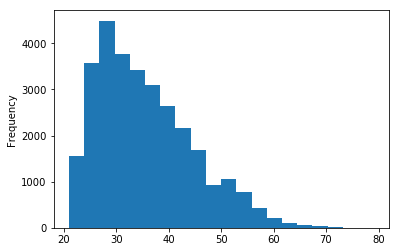

In [23]:
ccd["AGE"].plot.hist(bins=20)

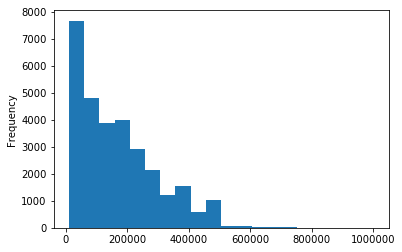

In [24]:
ccd["LIMIT_BAL"].plot.hist(bins=20)

- Visualizziamo una griglia di istogrammi per le variabili `PAY_n`, ovvero i mesi di ritardo nei precedenti pagamenti
  - essendoci pochi valori interi, invece di `hist` sulla serie usiamo `bar` su `value_counts` per visualizzare una barra per ciascuno

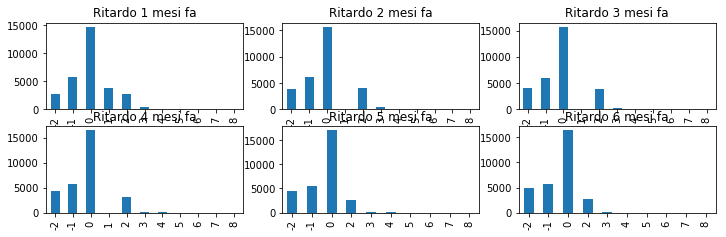

In [25]:
plt.figure(figsize=(12, 3.5))
for n in range(1, 7):
    ccd["PAY_{}".format(n)].value_counts().sort_index().plot.bar(title="Ritardo {} mesi fa".format(n), ax=plt.subplot(2, 3, n))

- Assumiamo che i valori -2 e -1 contino come 0, li sovrascriviamo e rigeneriamo i grafici

In [26]:
for n in range(1, 7):
    col = "PAY_{}".format(n)
    ccd.loc[ccd[col] < 0, col] = 0

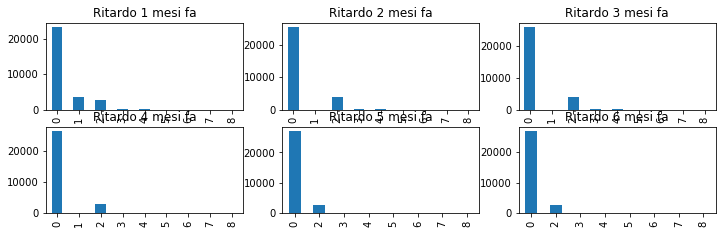

In [27]:
plt.figure(figsize=(12, 3.5))
for n in range(1, 7):
    ccd["PAY_{}".format(n)].value_counts().sort_index().plot.bar(title="Ritardo {} mesi fa".format(n), ax=plt.subplot(2, 3, n))

- Generiamo istogrammi in modo simile per le variabili `BILL_AMTn` e `PAY_AMTn`

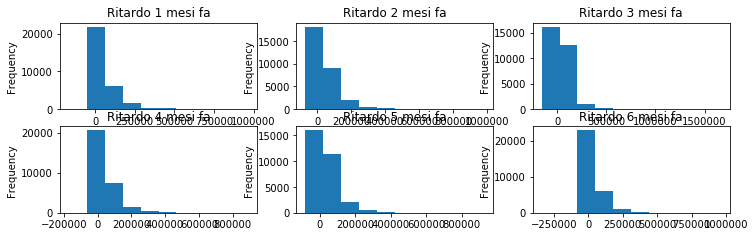

In [28]:
plt.figure(figsize=(12, 3.5))
for n in range(1, 7):
    ccd["BILL_AMT{}".format(n)].plot.hist(title="Ritardo {} mesi fa".format(n), ax=plt.subplot(2, 3, n))

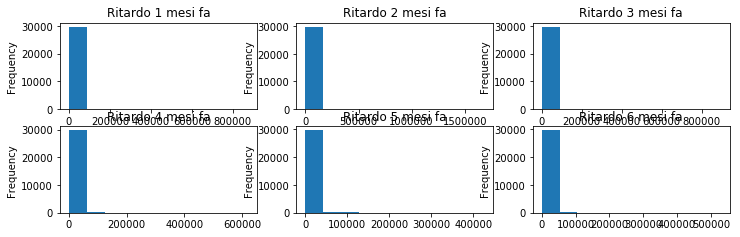

In [29]:
plt.figure(figsize=(12, 3.5))
for n in range(1, 7):
    ccd["PAY_AMT{}".format(n)].plot.hist(title="Ritardo {} mesi fa".format(n), ax=plt.subplot(2, 3, n))

## Divisione Training e Validation Set

- Finita l'analisi esploratoria e la correzione di alcune variabili, vediamo quali modelli possiamo addestrare per la classificazione
- Per iniziare, come al solito, usiamo la funzione `train_test_split` per suddividere casualmente il dataset in
  - un training set per l'addestramento dei modelli
  - un validation set per la loro valutazione
- Per ciascuno creiamo una serie y con la variabile `DEFAULT` da prevedere e un DataFrame X con le variabili utilizzabili per la predizione

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    ccd.drop(["DEFAULT"], axis=1),   #`X = tutto tranne DEFAULT
    ccd["DEFAULT"],                  # y = DEFAULT
    test_size=1/3, random_state=42   # opzioni
)

In [31]:
len(X_train), len(X_val)

(20000, 10000)

## Perceptron

- L'addestramento di un perceptron come di altri modelli di classificazione funziona come i modelli di regressione
- Dapprima creiamo il modello "vuoto" indicando eventuali parametri

In [32]:
from sklearn.linear_model import Perceptron
model = Perceptron()

- Usiamo quindi il metodo `fit` passando il training set, suddiviso tra le variabili predittive X e la variabile da predire y

In [33]:
model.fit(X_train, y_train)

/usr/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False)

## Predizioni

- Come per i modelli di regressione, usiamo il metodo `predict` per ottenere i valori di y predetti a fronte di valori di X dati
  - a differenza della regressione, tutte le predizioni saranno esattamente 0 (pagato) o 1 (insoluto)
- Estraiamo ad esempio le predizioni per il validation set

In [34]:
y_val_pred = model.predict(X_val)

- Otteniamo un array (senza etichette) con le predizioni date dal modello

In [35]:
y_val_pred[:10]

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0])

## Accuratezza

- Come valutare quanto sono buone queste predizioni?
- Nel caso dei modelli di regressione, dove veniva predetta una variabile continua, si misura _quanto_ la predizione sia sbagliata
- Nella classificazione vanno usate altre misure
- L'_accuratezza_ di un modello di classificazione è comunemente intesa come la percentuale di esempi di un set di valutazione per cui la classe predetta dal modello coincide con quella nota

- Dato il vettore che indica in quali casi la predizione è esatta...

In [36]:
hits = y_val == y_val_pred

- ...possiamo ottenere il numero di valori `True` con `sum` e la loro percentuale con `mean`

In [37]:
hits.sum()

6716

In [38]:
hits.mean()

0.6716

- La percentuale di classificazioni corrette è quindi il 67\%, circa due terzi del dataset
- Possiamo ottenere tale percentuale rapidamente tramite il metodo `score` del modello, fornendo il set di dati per la valutazione

In [39]:
model.score(X_val, y_val)

0.6716

In [40]:
model = Perceptron(penalty="l2")
model.fit(X_train, y_train)
model.score(X_val, y_val)

/usr/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.7782

## Parametri del Modello

- Come per i modelli di regressione, possiamo vedere i parametri del modello per stimare l'importanza delle variabili
- I coefficienti per cui è moltiplicata ciascuna variabile sono dati dall'attributo `coef_`

In [41]:
model.coef_

array([[-8.09401279e+05,  5.79528531e+02,  7.95008885e+02,
         5.76558771e+02,  1.43440862e+04,  1.28321094e+03,
         1.09071584e+03,  9.40637266e+02,  8.38510860e+02,
         7.41625416e+02,  7.06163892e+02, -1.56635116e+05,
         4.26497842e+05, -3.20652516e+04,  1.50667146e+05,
         2.34252573e+05,  1.57108525e+05,  5.65755006e+04,
         2.14766018e+05, -1.35235455e+05,  1.42270141e+05,
        -1.25998965e+05, -1.98200216e+05]])

- Avendo le variabili scale diverse, è però difficile confrontarne l'importanza

- Come visto per i modelli di regressione, utilizziamo una pipeline per standardizzare le variabili prima di fornirle al modello

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
model = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  Perceptron())
])
model.fit(X_train, y_train);

/usr/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [43]:
model.score(X_val, y_val)

/usr/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.7165

- La standardizzazione ha contribuito ad aumentare l'accuratezza

- Vediamo ora i coefficienti di `Perceptron`, associandoli ai nomi delle variabili

In [44]:
pd.Series(model.named_steps["model"].coef_[0], index=X_train.columns)

LIMIT_BAL    -3.492098
SEX          -1.871292
EDUCATION    -5.918559
MARRIAGE     -1.301209
AGE           3.716737
PAY_1         4.431453
PAY_2        -1.438510
PAY_3        -6.944936
PAY_4        -1.483437
PAY_5         4.633193
PAY_6         7.575230
BILL_AMT1     3.430693
BILL_AMT2     6.543703
BILL_AMT3     1.419087
BILL_AMT4     0.648952
BILL_AMT5     5.578438
BILL_AMT6    -1.846068
PAY_AMT1     -4.596413
PAY_AMT2     12.527017
PAY_AMT3     -0.834223
PAY_AMT4      2.219242
PAY_AMT5     -6.357373
PAY_AMT6     -7.194857
dtype: float64

## Regolarizzazione

- Nel modello `Perceptron` è possibile applicare i differenti tipi di regolarizzazione visti nella regressione
  - la regolarizzazione `l2` limita i valori assoluti dei parametri del modello per evitare overfitting
  - `l1` fa sì che alcuni parametri siano nulli per scartare le variabili meno necessarie
  - `elasticnet` combina le due sopra
- Col parametro `penalty` si imposta il tipo di regolarizzazione, con `alpha` l'intensità
- Testiamo ad esempio un modello con regolarizzazione L1

In [45]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  Perceptron(penalty="l1", alpha=0.0005))
])
model.fit(X_train, y_train)
model.score(X_val, y_val)

/usr/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.7844

- I parametri di questo modello sono:

In [46]:
model.named_steps["model"].coef_

array([[ 0.        ,  0.        , -0.28980275,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.18182255,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ]])

- Vediamo che sono considerate solo due variabili, che sono...

In [47]:
X_train.columns[model.named_steps["model"].coef_[0] != 0]

Index(['EDUCATION', 'PAY_6'], dtype='object')

## Regressione Logistica

- La regressione _logistica_ è un modello di classificazione binaria basato sulla regressione lineare
- Sia data una variabile y pari a 1 per gli esempi di una classe (positiva) e -1 per quelli dell'altra (negativa), si minimizza la funzione
$$ \sum_{i=1}^n \log(\exp(- y_i (X_i^T w + c)) + 1) $$
- Per addestrare tale modello, creiamo un oggetto `LogisticRegression`

In [48]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
model.score(X_val, y_val)

/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7818

- Testiamo un modello simile con la standardizzazione

In [49]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  LogisticRegression())
])
model.fit(X_train, y_train)
model.score(X_val, y_val)

/usr/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.8171

- Di default in `LogisticRegression` viene applicata la regolarizzazione L2, si può impostare `penalty="l1"` per applicare la L1
- Al posto del parametro `alpha` che imposta il peso della regolarizzazione, c'è un parametro `C` (_costo_) che imposta il **reciproco** di tale peso
  - maggiore è C, minore sarà la regolarizzazione

In [53]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  LogisticRegression(penalty="l1", C=10))
])
model.fit(X_train, y_train)
model.score(X_val, y_val)

/usr/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.817

## Support Vector Machines

- Le _support vector machines_ sono un modello utilizzabile sia per la classificazione che la regressione
- Per la classificazione creiamo un oggetto `SVC` (support vector classification)
- Tra i parametri possiamo impostare il costo C (come per `LogisticRegression`) e il kernel da utilizzare con relativi parametri (come per `KernelRidge`)

In [54]:
from sklearn.svm import SVC
model = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  SVC(kernel="linear"))
])
model.fit(X_train, y_train)

/usr/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [55]:
model.score(X_val, y_val)

/usr/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.8203

In [56]:
%%time
model = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  SVC(kernel="rbf"))
])
model.fit(X_train, y_train)

/usr/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


CPU times: user 13 s, sys: 16.5 ms, total: 13 s
Wall time: 13 s


In [57]:
model.score(X_val, y_val)

/usr/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.8179

## Matrice di Confusione, Precision e Recall

- Abbiamo visto modelli che classificano correttamente fino all'82\% di esempi del validation set
- Tuttavia, considerando la distribuzione delle due classi nel validation set...

In [58]:
y_val.value_counts(normalize=True)

0    0.7818
1    0.2182
Name: DEFAULT, dtype: float64

- ...un semplice classificatore che predica sempre 0 (pagato) avrebbe un'accuratezza del 78\%
- L'accuratezza può essere quindi ingannevole in caso di classi sbilanciate
- Vediamo quindi altri modi di misurare le performance di un classificatore

- Confrontando le classi predette da un classificatore su un set di dati con quelle reali, possiamo ottenere una **_matrice di confusione_**
- Ogni cella in riga i e colonna j indica quanti esempi della classe i-esima sono stati etichettati dal classificatore come di classe j-esima
  - lungo la diagonale (i=j) abbiamo quindi le classificazioni corrette, al di fuori abbiamo gli errori
- Otteniamo la matrice col metodo `confusion_matrix`, passando i vettori di classi reali e predette

In [59]:
from sklearn.metrics import confusion_matrix
y_val_pred = model.predict(X_val)
cm = confusion_matrix(y_val, y_val_pred)

/usr/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [60]:
cm

array([[7410,  408],
       [1413,  769]])

- Per maggiore comprensione inseriamo i valori in un DataFrame, etichettando righe e colonne

In [61]:
classes = ["Paid", "Default"]
pd.DataFrame(cm, index=classes, columns=classes)

Paid  Default
Paid     7410      408
Default  1413      769

- Ad esempio, di 2182 clienti insolventi presenti nel validation set
  - 769 sono stati etichettati come tali (_veri positivi_)
  - 1413 sono stati erroneamente etichettati come non insolventi (_falsi negativi_)
- L'accuratezza si può ottenere dalla matrice di confusione come somma dei valori nella diagonale divisa per la somma complessiva

In [62]:
cm.diagonal().sum() / cm.sum()

0.8179

- Dalla sola matrice di confusione possiamo ricavare altre misure di performance importanti
- Presa una classe X di riferimento, la **_precision_** relativa a quella classe indica la percentuale di esempi classificati come X che sono realmente tali

In [63]:
default_prc = cm[1, 1] / cm[:, 1].sum()
default_prc

0.653355989804588

- Di contro, la **_recall_** indica la percentuale di esempi realmente di classe X che sono stati rilevati essere tali dal modello

In [64]:
default_rec = cm[1, 1] / cm[1, :].sum()
default_rec

0.3524289642529789

- Precision e recall sono quindi due indicatori complementari della bontà di un modello
- Generalmente, tarando il modello per migliorarne uno, l'altro peggiora
- Come misura unica della performance di un modello è spesso usata quindi la **_F1-measure_**, ovvero la media armonica tra precision e recall
$$ F_1 = \frac{2\cdot P\cdot R}{P+R} $$

In [65]:
2 * default_prc * default_rec / (default_prc + default_rec)

0.45787436737124143

- Per calcolare direttamente tali misure, scikit-learn fornisce le funzioni `precision_score`, `recall_score` e `f1_score`
  - col parametro `pos_label` si indica la classe di riferimento, di default 1
  - si può in alternativa ottenere un vettore di punteggi per tutte le classi (`average=None`) o la loro media (`average="macro"`)

In [66]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [67]:
precision_score(y_val, y_val_pred, pos_label=1)

0.653355989804588

In [68]:
recall_score(y_val, y_val_pred)   # pos_label=1 sottinteso

0.3524289642529789

In [69]:
f1_score(y_val, y_val_pred, average=None)

array([0.89057148, 0.45787437])

In [70]:
f1_score(y_val, y_val_pred, average="macro")

0.6742229237252817

## Ottimizzazione degli Iperparametri

- Come già visto, i modelli hanno diversi iperparametri impostabili che possono influenzarne l'accuratezza
- Utilizziamo la _grid search_ per testare diverse combinazioni di iperparametri e trovare quella che fornisce risultati migliori
- Impostiamo un modello generale, definendone struttura ed eventuali iperparametri fissi

In [71]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("perc",   Perceptron())
])

- Definiamo quindi una _griglia_ di parametri da variare, in questo caso il tipo e il peso della regolarizzazione
  - `X__Y` indica il parametro `Y` del componente `X` della pipeline

In [72]:
grid = {
    "perc__penalty": [None, "l1", "l2", "elasticnet"],
    "perc__alpha": np.logspace(-3, 3, 7)   # [0.001, 0.01, ..., 100, 1000]
}

- Creiamo quindi un modello `GridSearchCV` con i due oggetti definiti sopra...

In [73]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(model, grid)

- ...ed addestriamolo sul training set

In [74]:
gs.fit(X_train, y_train);

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, a

- Viene eseguita una cross validation su tutte le combinazioni di iperparametri e per quella con migliore accuratezza (`score`) viene addestrato un modello su tutti i dati
- Possiamo testare tale modello sul validation set

In [75]:
gs.score(X_val, y_val)

/usr/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.7818

- Possiamo inoltre consultare i risultati dettagliati sulle diverse combinazioni di iperparametri
  - ordinando per `rank_test_score` otteniamo in testa i risultati migliori

In [76]:
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)

/usr/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
13       0.018171      0.000300         0.001950        0.000038   
25       0.022750      0.001194         0.002021        0.000041   
23       0.018607      0.000920         0.002057        0.000221   
22       0.013433      0.000030         0.001817        0.000030   
21       0.020583      0.002839         0.001995        0.000165   

   param_perc__alpha param_perc__penalty  \
13                 1                  l1   
25              1000                  l1   
23               100          elasticnet   
22               100                  l2   
21               100                  l1   

                                               params  split0_test_score  \
13        {'perc__alpha': 1.0, 'perc__penalty': 'l1'}           0.777261   
25     {'perc__alpha': 1000.0, 'perc__penalty': 'l1'}           0.777261   
23  {'perc__alpha': 100.0, 'perc__penalty': 'elast...           0.777261   
22      {'perc__alpha': 100.0, 'perc__penalty': 'l2'}           0.777261   
21      {'perc__alpha': 100.0, 'perc__penalty': 'l1'}           0.777261   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
13           0.777261           0.777378           0.7773        0.000055   
25           0.777261           0.777378           0.7773        0.000055   
23           0.777261           0.777378           0.7773        0.000055   
22           0.777261           0.777378           0.7773        0.000055   
21           0.777261           0.777378           0.7773        0.000055   

    rank_test_score  split0_train_score  split1_train_score  \
13                1            0.777319            0.777319   
25                1            0.777319            0.777319   
23                1            0.777319            0.777319   
22                1            0.777319            0.777319   
21                1            0.777319            0.777319   

    split2_train_score  mean_train_score  std_train_score  
13            0.777261            0.7773         0.000027  
25            0.777261            0.7773         0.000027  
23            0.777261            0.7773         0.000027  
22            0.777261            0.7773         0.000027  
21            0.777261            0.7773         0.000027

- Nel modello generale abbiamo imposto la standardizzazione ai dati, ma può non essere necessaria
- Possiamo impostare la griglia in modo da rendere opzionale un componente della pipeline

In [77]:
grid = {
    "scaler": [None, StandardScaler()],
    "perc__penalty": ["l1", "l2", "elasticnet"],
    "perc__alpha": np.logspace(0, 3, 4)
}

- In questo modo, la grid search testerà il modello con (`StandardScaler()`) e senza (`None`) standardizzazione

In [78]:
gs = GridSearchCV(model, grid)
gs.fit(X_train, y_train);

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  

In [79]:
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)

/usr/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
11       0.018464      0.001064         0.001967        0.000257   
21       0.013316      0.000149         0.001757        0.000041   
20       0.009893      0.000209         0.001218        0.000032   
19       0.016992      0.000145         0.001776        0.000026   
18       0.013154      0.000699         0.001365        0.000155   

   param_perc__alpha param_perc__penalty  \
11                10          elasticnet   
21              1000                  l2   
20              1000                  l2   
19              1000                  l1   
18              1000                  l1   

                                         param_scaler  \
11  StandardScaler(copy=True, with_mean=True, with...   
21  StandardScaler(copy=True, with_mean=True, with...   
20                                               None   
19  StandardScaler(copy=True, with_mean=True, with...   
18                                               None   

                                               params  split0_test_score  \
11  {'perc__alpha': 10.0, 'perc__penalty': 'elasti...           0.777261   
21  {'perc__alpha': 1000.0, 'perc__penalty': 'l2',...           0.777261   
20  {'perc__alpha': 1000.0, 'perc__penalty': 'l2',...           0.777261   
19  {'perc__alpha': 1000.0, 'perc__penalty': 'l1',...           0.777261   
18  {'perc__alpha': 1000.0, 'perc__penalty': 'l1',...           0.777261   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
11           0.777261           0.777378           0.7773        0.000055   
21           0.777261           0.777378           0.7773        0.000055   
20           0.777261           0.777378           0.7773        0.000055   
19           0.777261           0.777378           0.7773        0.000055   
18           0.777261           0.777378           0.7773        0.000055   

    rank_test_score  split0_train_score  split1_train_score  \
11                1            0.777319            0.777319   
21                1            0.777319            0.777319   
20                1            0.777319            0.777319   
19                1            0.777319            0.777319   
18                1            0.777319            0.777319   

    split2_train_score  mean_train_score  std_train_score  
11            0.777261            0.7773         0.000027  
21            0.777261            0.7773         0.000027  
20            0.777261            0.7773         0.000027  
19            0.777261            0.7773         0.000027  
18            0.777261            0.7773         0.000027

- Testiamo in modo simile la regressione logistica

In [80]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr",     LogisticRegression())
])
grid = {
    "scaler": [None, StandardScaler()],
    "lr__penalty": ["l2", "l1"],
    "lr__C": np.logspace(-3, 3, 7)
}
gs = GridSearchCV(model, grid)
gs.fit(X_train, y_train);

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to floa

In [82]:
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)

/usr/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_lr__C  \
9        0.051000      0.004192         0.001918        0.000002         0.1   
18       0.143892      0.009891         0.001549        0.000141          10   
14       0.158875      0.019693         0.001425        0.000007           1   
22       0.133254      0.020470         0.001444        0.000003         100   
26       0.150893      0.016464         0.001784        0.000452        1000   

   param_lr__penalty                                       param_scaler  \
9                 l2  StandardScaler(copy=True, with_mean=True, with...   
18                l1                                               None   
14                l1                                               None   
22                l1                                               None   
26                l1                                               None   

                                               params  split0_test_score  \
9   {'lr__C': 0.1, 'lr__penalty': 'l2', 'scaler': ...           0.820009   
18  {'lr__C': 10.0, 'lr__penalty': 'l1', 'scaler':...           0.820159   
14  {'lr__C': 1.0, 'lr__penalty': 'l1', 'scaler': ...           0.820159   
22  {'lr__C': 100.0, 'lr__penalty': 'l1', 'scaler'...           0.820159   
26  {'lr__C': 1000.0, 'lr__penalty': 'l1', 'scaler...           0.820159   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
9            0.817159           0.817732          0.81830        0.001231   
18           0.817159           0.817432          0.81825        0.001354   
14           0.817159           0.817432          0.81825        0.001354   
22           0.817159           0.817282          0.81820        0.001386   
26           0.817009           0.817432          0.81820        0.001396   

    rank_test_score  split0_train_score  split1_train_score  \
9                 1            0.816470            0.819320   
18                2            0.816695            0.819770   
14                2            0.816545            0.819845   
22                4            0.816545            0.819695   
26                4            0.816620            0.819770   

    split2_train_score  mean_train_score  std_train_score  
9             0.820159          0.818650         0.001579  
18            0.820234          0.818900         0.001570  
14            0.820309          0.818900         0.001676  
22            0.820084          0.818775         0.001584  
26            0.820234          0.818875         0.001605

- Di default i modellli sono ritenuti migliori di altri in base all'accuratezza, cioè la percentuale di classificazioni corrette
- Col parametro `scoring` di `GridSearchCV` possiamo però definire una diversa metrica di paragone
- Basiamoci ad esempio sulla F1-measure, impostando `scoring="f1"`

In [83]:
gs = GridSearchCV(model, grid, scoring="f1")
gs.fit(X_train, y_train);

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due 

- Questa volta la colonna `mean_test_score` (e tutte le altre `*_score`) riportano la F1 al posto dell'accuratezza e il ranking dei modelli è basato su di essa

In [84]:
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)

/usr/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_lr__C  \
9        0.053626      0.003809         0.002897        0.000303         0.1   
18       0.125189      0.020912         0.002450        0.000310          10   
14       0.144731      0.018117         0.002112        0.000016           1   
15       0.113844      0.007589         0.002642        0.000053           1   
26       0.148496      0.005262         0.002203        0.000114        1000   

   param_lr__penalty                                       param_scaler  \
9                 l2  StandardScaler(copy=True, with_mean=True, with...   
18                l1                                               None   
14                l1                                               None   
15                l1  StandardScaler(copy=True, with_mean=True, with...   
26                l1                                               None   

                                               params  split0_test_score  \
9   {'lr__C': 0.1, 'lr__penalty': 'l2', 'scaler': ...           0.447514   
18  {'lr__C': 10.0, 'lr__penalty': 'l1', 'scaler':...           0.447926   
14  {'lr__C': 1.0, 'lr__penalty': 'l1', 'scaler': ...           0.446494   
15  {'lr__C': 1.0, 'lr__penalty': 'l1', 'scaler': ...           0.446799   
26  {'lr__C': 1000.0, 'lr__penalty': 'l1', 'scaler...           0.447211   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
9            0.442105           0.471509         0.453709        0.012778   
18           0.442105           0.469254         0.453094        0.011670   
14           0.442105           0.469717         0.452771        0.012115   
15           0.442105           0.469050         0.452650        0.011752   
26           0.441392           0.469254         0.452618        0.012000   

    rank_test_score  split0_train_score  split1_train_score  \
9                 1            0.441707            0.455839   
18                2            0.441653            0.456704   
14                3            0.441553            0.457156   
15                4            0.441807            0.456949   
26                5            0.441653            0.457052   

    split2_train_score  mean_train_score  std_train_score  
9             0.464493          0.454013         0.009392  
18            0.465075          0.454477         0.009690  
14            0.465179          0.454629         0.009809  
15            0.466310          0.455022         0.010095  
26            0.465075          0.454594         0.009719